In [1]:
%%capture
!pip install langchain_community
!pip install langchain
!pip install streamlit
!pip install rouge-score
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes
!pip install datasets
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install bitsandbytes

In [2]:
from langchain.memory import ChatMessageHistory
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_community.utilities.sql_database import SQLDatabase
import sqlite3
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from transformers import LlamaTokenizer, LlamaForCausalLM, AutoTokenizer
import torch
import numpy as np
from datasets import load_dataset
from unsloth import FastLanguageModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

/home/raj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
text_to_sql_tmpl_str = """\
### Instruction:\n{system_message}{user_message}\n\n### Response:\n{response}"""

text_to_sql_inference_tmpl_str = """\
### Instruction:\n{system_message}{user_message}\n\n### Response:\n"""

def _generate_prompt_sql(input, context, dialect="sqlite", output="", messages=""):
    system_message = f"""You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question. Use the previous conversation to answer the follow up questions. Do not provide any explanation

    """
    user_message = f"""### Dialect:
{dialect}

### Input:
{input}

### Context:
{context}

### Previous Conversation:
{messages}

"""
    if output:
        return text_to_sql_tmpl_str.format(
            system_message=system_message,
            user_message=user_message,
            response=output,
        )
    else:
        return text_to_sql_inference_tmpl_str.format(
            system_message=system_message, user_message=user_message
        )

def generate_prompt(data_point):
    full_prompt = _generate_prompt_sql(
        data_point["instruction"],
        data_point["input"],
        dialect="sqlite",
        # output=data_point["sql"],
    )
    return full_prompt

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
datasetid = ['determined-ai/text-to-sql-easy', 'determined-ai/text-to-sql-medium', 'determined-ai/text-to-sql-hard']

In [ ]:
dfs = []
for dataset_id in datasetid:
  test = load_dataset(dataset_id, split="test")
  test = pd.DataFrame(test)
  test['Complexity'] = dataset_id.split('-')[-1]
  dfs.append(test)
  valid = load_dataset(dataset_id, split="valid")
  valid = pd.DataFrame(valid)
  valid['Complexity'] = dataset_id.split('-')[-1]
  dfs.append(valid)

merged_df = pd.concat(dfs, ignore_index=True)

In [ ]:
# Store the result in a new "text" column
merged_df["prompt"] = merged_df.apply(lambda x: generate_prompt(x), axis=1)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("basavaraj/text2sql-Llama3-8b")
model = LlamaForCausalLM.from_pretrained(
    "basavaraj/text2sql-Llama3-8b",
    load_in_4bit=True,
    torch_dtype=torch.float16,)
FastLanguageModel.for_inference(model)

In [ ]:
import time

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
initial_start = time.time()
Inference_time = 0

# Iterate over each row in the category_df
for index, row in merged_df.iterrows():
    print("index : ", index)
    start = time.time()
    inputs = row['prompt']
    expected_query = row['response']

    # Tokenize inputs
    inputs = tokenizer(inputs, return_tensors="pt").to("cuda")

    # Generate SQL queries for the batch
    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
    input_length = inputs["input_ids"].shape[1]
    response = tokenizer.batch_decode(outputs[:, input_length:], skip_special_tokens=True)
    query = response[0]


    merged_df.loc[merged_df['response'] == expected_query, 'generated_query'] = query
    bleu = sentence_bleu([expected_query.split()], query.split())
    rouge = scorer.score(expected_query, query)
    rouge_score = (rouge['rouge1'].fmeasure + rouge['rouge2'].fmeasure + rouge['rougeL'].fmeasure) / 3
    merged_df.loc[merged_df['response'] == expected_query, 'bleu_score'] = bleu
    merged_df.loc[merged_df['response'] == expected_query, 'rouge_score'] = rouge_score

merged_df.to_excel("result", index=False)
print("Inference time =", time.time() - initial_start)

In [ ]:
merged_df.head()

,instruction,input,response,Complexity,prompt,generated_query,bleu_score,rouge_score
0,Which year had a publication of Pazz & Jop?,CREATE TABLE table_name_99 (\n year VARCHAR...,SELECT year FROM table_name_99 WHERE publicati...,easy,### Instruction:\nYou are a powerful text-to-S...,SELECT year FROM table_name_99 WHERE publicati...,6.606329e-01,1.000000
1,Who was the finalist in Miami?,CREATE TABLE table_name_7 (\n finalist VARC...,SELECT finalist FROM table_name_7 WHERE tourna...,easy,### Instruction:\nYou are a powerful text-to-S...,SELECT finalist FROM table_name_7 WHERE tourna...,8.408964e-01,1.000000
2,Find the details for all chip models.,CREATE TABLE screen_mode (\n graphics_mode ...,SELECT * FROM chip_model,easy,### Instruction:\nYou are a powerful text-to-S...,SELECT DISTINCT chip_model.model_name FROM chi...,1.140985e-231,0.241758
3,What are the names of stations that have latit...,"CREATE TABLE station (\n name VARCHAR,\n ...",SELECT name FROM station WHERE lat < 37.5,easy,### Instruction:\nYou are a powerful text-to-S...,SELECT name FROM station WHERE lat < 37.5,1.000000e+00,1.000000
4,Retrieve the country that has published the mo...,"CREATE TABLE inst (\n instid number,\n n...",SELECT t1.country FROM inst AS t1 JOIN authors...,easy,### Instruction:\nYou are a powerful text-to-S...,SELECT country FROM inst WHERE instid IN (SELE...,1.393752e-01,0.452144


In [ ]:
mean_BS = merged_df['bleu_score'].mean()
mean_RS = merged_df['rouge_score'].mean()
print("mean_BS : ", mean_BS)
print("mean_RS : ", mean_RS)

mean_BS :  0.5777918217883167
mean_RS :  0.7975033486930645


In [ ]:
scores = {}
for dataset_id in datasetid:
  complexity = dataset_id.split('-')[-1]
  print("Complexity : ", complexity)
  mean_BS = merged_df.loc[merged_df['Complexity'] == complexity, 'bleu_score'].mean()
  mean_RS = merged_df.loc[merged_df['Complexity'] == complexity, 'rouge_score'].mean()
  print("mean_BS : ", mean_BS)
  print("mean_RS : ", mean_RS)

Complexity :  easy
mean_BS :  0.5777918217883167
mean_RS :  0.7975033486930645
Complexity :  medium
mean_BS :  nan
mean_RS :  nan
Complexity :  hard
mean_BS :  nan
mean_RS :  nan


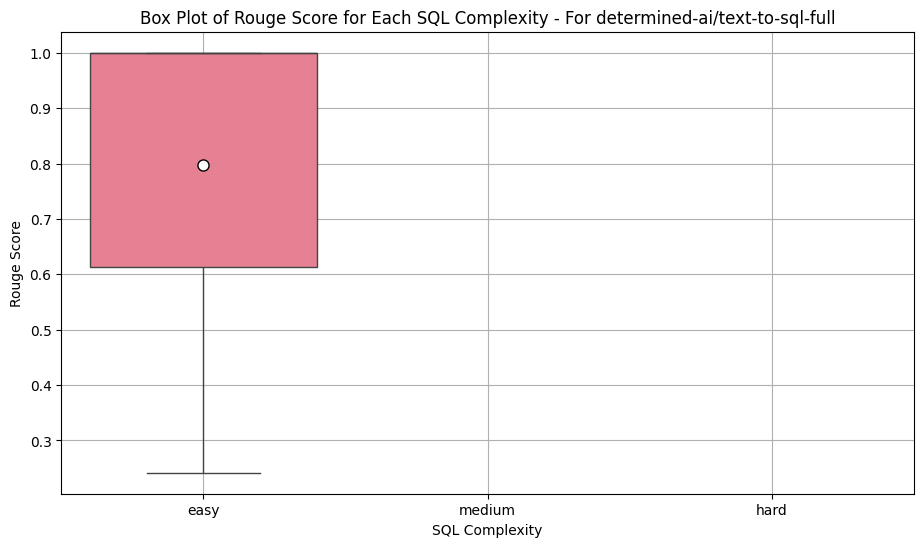

In [ ]:
plt.figure(figsize=(11,6))
# create 3rd grouped boxplot
sns.boxplot(x = merged_df['Complexity'],
			y = merged_df['rouge_score'],
			hue = merged_df['Complexity'],
			palette = 'husl', showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})


# Add labels and title
plt.xlabel('SQL Complexity')
plt.ylabel('Rouge Score')
plt.title('Box Plot of Rouge Score for Each SQL Complexity - For determined-ai/text-to-sql-full')
plt.grid(True)
plt.savefig(os.path.join("./", f"Rouge_Score.png"))

In [ ]:
plt.figure(figsize=(11,6))
# create 3rd grouped boxplot
sns.boxplot(x = merged_df['Complexity'],
			y = merged_df['bleu_score'],
			hue = merged_df['Complexity'],
			palette = 'husl', showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})


# Add labels and title
plt.xlabel('SQL Complexity')
plt.ylabel('Bleu Score')
plt.title('Box Plot of Bleu Score for Each SQL Complexity - For determined-ai/text-to-sql-full')
plt.grid(True)
plt.savefig(os.path.join("./", f"Bleu_Score.png"))

In [ ]:
selected_df = merged_df[['bleu_score', 'rouge_score']]

# Create box plot using seaborn
sns.boxplot(data=selected_df, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})

# Add labels and title
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.title('Box Plot of BLEU Score and ROGUE Score - For determined-ai/text-to-sql-full')
plt.grid(True)
plt.savefig(os.path.join("./", f"Mean_Score.png"))